In [103]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

In [104]:
df1 = pd.read_csv('/Users/pradeep/exp/capstone/data/Fine_2014_2019_Finger_millet_Min_Blore_Mysore.csv')
df1.head()

,district,commodity,Arrival Date,variety,Min_price
0,Mysore,Ragi (Finger Millet),02-01-14,Fine,1600
1,Mysore,Ragi (Finger Millet),03-01-14,Fine,2000
2,Mysore,Ragi (Finger Millet),04-01-14,Fine,1800
3,Mysore,Ragi (Finger Millet),07-01-14,Fine,2000
4,Mysore,Ragi (Finger Millet),08-01-14,Fine,2100


In [105]:
gp = pd.pivot_table(df1,values='Min_price',columns=['district','commodity'],index=['Arrival Date'])
#gp = gp.sort_index(axis='columns', level='Arrival Date')
gp.head()

district,Bangalore,Mysore
commodity,Ragi (Finger Millet),Ragi (Finger Millet)
Arrival Date,,
01-01-15,1900,1900
01-01-16,1800,1800
01-01-18,2800,2800
01-01-19,2800,2800
01-02-15,1900,1900


In [106]:
flattened = pd.DataFrame(gp.to_records())
flattened['Arrival Date'] = pd.to_datetime(flattened['Arrival Date'])
flattened = flattened.sort_values(by=['Arrival Date'])
df = flattened.reset_index()
del df['index']
df

,Arrival Date,"('Bangalore', 'Ragi (Finger Millet)')","('Mysore', 'Ragi (Finger Millet)')"
0,2014-01-03,1800,1800
1,2014-01-04,1800,1800
2,2014-01-06,1800,1800
3,2014-01-07,1700,1700
4,2014-01-08,1850,1850
5,2014-01-09,1700,1700
6,2014-01-10,1850,1850
7,2014-01-13,1850,1850
8,2014-01-16,1850,1850
9,2014-01-17,1700,1700


In [107]:
ndf = df.fillna(method='ffill')

In [108]:
ndf.to_csv('/Users/pradeep/exp/capstone/data/Finger_millet_2006_2019_Complete_after_PreProcessing.csv', encoding='utf-8')

In [109]:
df = pd.read_csv('/Users/pradeep/exp/capstone/data/Finger_millet_2006_2019_Complete_after_PreProcessing.csv')
del df['Unnamed: 0']
df.head()

,Arrival Date,"('Bangalore', 'Ragi (Finger Millet)')","('Mysore', 'Ragi (Finger Millet)')"
0,2014-01-03,1800,1800
1,2014-01-04,1800,1800
2,2014-01-06,1800,1800
3,2014-01-07,1700,1700
4,2014-01-08,1850,1850


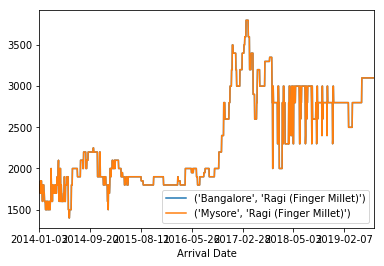

In [110]:
df.plot(x='Arrival Date')

In [111]:
df['Arrival Date'] = pd.to_datetime(df['Arrival Date']).astype('int')
df.describe()

,Arrival Date,"('Bangalore', 'Ragi (Finger Millet)')","('Mysore', 'Ragi (Finger Millet)')"
count,1.320000e+03,1320.000000,1320.000000
mean,1.474445e+18,2351.060606,2351.060606
std,5.209773e+16,560.399318,560.399318
min,1.388707e+18,1400.000000,1400.000000
25%,1.430482e+18,1900.000000,1900.000000
50%,1.470744e+18,2100.000000,2100.000000
75%,1.523362e+18,2800.000000,2800.000000
max,1.565222e+18,3800.000000,3800.000000


In [222]:
training_set = df.iloc[:,[1,2]].values
training_set

array([[1800, 1800],
       [1800, 1800],
       [1800, 1800],
       ...,
       [3100, 3100],
       [3100, 3100],
       [3100, 3100]])

In [223]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(training_set)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [224]:
train_size = int(len(scaled) * 0.80)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 1056
test: 264


In [225]:
print(train.shape)
print(test.shape)

(1056, 2)
(264, 2)


In [226]:
train

array([[0.16666667, 0.16666667],
       [0.16666667, 0.16666667],
       [0.16666667, 0.16666667],
       ...,
       [0.5       , 0.5       ],
       [0.58333333, 0.58333333],
       [0.58333333, 0.58333333]])

In [255]:
def create_dataset(dataset, look_back=32):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print("a:")
        print(a)
        print('Y {}'.format(i + look_back))
        b = dataset[i + look_back]
        print(b)
        #dataset[i + look_back,1:2]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [256]:
look_back = 17
#32
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1056 17
0
X 0 to 17
a:
[[0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.125      0.125     ]
 [0.1875     0.1875    ]
 [0.125      0.125     ]
 [0.1875     0.1875    ]
 [0.1875     0.1875    ]
 [0.1875     0.1875    ]
 [0.125      0.125     ]
 [0.125      0.125     ]
 [0.125      0.125     ]
 [0.08333333 0.08333333]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]]
Y 17
[0.16666667 0.16666667]
1
X 1 to 18
a:
[[0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.125      0.125     ]
 [0.1875     0.1875    ]
 [0.125      0.125     ]
 [0.1875     0.1875    ]
 [0.1875     0.1875    ]
 [0.1875     0.1875    ]
 [0.125      0.125     ]
 [0.125      0.125     ]
 [0.125      0.125     ]
 [0.08333333 0.08333333]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]]
Y 18
[0.125 0.125]
2
X 2 to 19
a:
[[0.16666667 0.16666667]
 [0.125      0.125    

Y 193
[0.33333333 0.33333333]
177
X 177 to 194
a:
[[0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.25       0.25      ]
 [0.25       0.25      ]
 [0.25       0.25      ]
 [0.25       0.25      ]
 [0.29166667 0.29166667]
 [0.29166667 0.29166667]
 [0.29166667 0.29166667]
 [0.29166667 0.29166667]
 [0.29166667 0.29166667]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]]
Y 194
[0.33333333 0.33333333]
178
X 178 to 195
a:
[[0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.25       0.25      ]
 [0.25       0.25      ]
 [0.25       0.25      ]
 [0.25       0.25      ]
 [0.29166667 0.29166667]
 [0.29166667 0.29166667]
 [0.29166667 0.29166667]
 [0.29166667 0.29166667]
 [0.29166667 0.29166667]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]]
Y 195
[0.33333333 0.33333333]
179
X 179 to 196
a

 [0.20833333 0.20833333]]
Y 364
[0.20833333 0.20833333]
348
X 348 to 365
a:
[[0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]]
Y 365
[0.20833333 0.20833333]
349
X 349 to 366
a:
[[0.16666667 0.16666667]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]]
Y 366
[0.20833333 0.20

 [0.20833333 0.20833333]]
Y 546
[0.20833333 0.20833333]
530
X 530 to 547
a:
[[0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]]
Y 547
[0.1875 0.1875]
531
X 531 to 548
a:
[[0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.16666667 0.16666667]
 [0.20833333 0.20833333]
 [0.20833333 0.20833333]
 [0.1875     0.1875    ]]
Y 548
[0.1875 0.1875]
532
X 53

 [0.58333333 0.58333333]]
Y 729
[0.58333333 0.58333333]
713
X 713 to 730
a:
[[0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]]
Y 730
[0.58333333 0.58333333]
714
X 714 to 731
a:
[[0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.33333333 0.33333333]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.41666667 0.41666667]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]]
Y 731
[0.5 0.5]
715
X 

897
X 897 to 914
a:
[[0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]]
Y 914
[0.8125 0.8125]
898
X 898 to 915
a:
[[0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.79166667 0.79166667]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]
 [0.8125     0.8125    ]]
Y 915
[0.8125 0.8125]
899
X 899 to 916
a:
[[0.79166667 0.79166667]
 [0.79166667 0.7916

[0.5 0.5]
44
X 44 to 61
a:
[[0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.41666667 0.41666667]
 [0.66666667 0.66666667]
 [0.66666667 0.66666667]
 [0.5        0.5       ]]
Y 61
[0.58333333 0.58333333]
45
X 45 to 62
a:
[[0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.58333333 0.58333333]
 [0.41666667 0.41666667]
 [0.66666667 0.66666667]
 [0.66666667 0.66666667]
 [0.5        0.5       ]
 [0.58333333 0.58333333]]
Y 62
[0.58333333 0.58333333]
46
X 46 to 63
a:
[[0.58333333 0.58333333]
 [0.

[0.70833333 0.70833333]
227
X 227 to 244
a:
[[0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]]
Y 244
[0.70833333 0.70833333]
228
X 228 to 245
a:
[[0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]
 [0.70833333 0.70833333]]
Y 245
[0.70833333 0.70833333]
229
X 229 to 246
a:
[[0.

In [257]:
y_train[0]

array([0.16666667, 0.16666667])

In [258]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1038, 17, 2)
(246, 17, 2)
(1038, 2)
(246, 2)


In [259]:
#X_test

In [260]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],X_train.shape[2] ))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
print(X_train.shape)
print(X_test.shape)

(1038, 17, 2)
(246, 17, 2)


In [261]:
batch_size = 1
model = Sequential()
model.add(LSTM(units=200, batch_input_shape=(batch_size, look_back, 2), stateful=True))
#model.add(LSTM(50, return_sequences=True))  
#model.add(LSTM(units=100, batch_input_shape=(batch_size, look_back, 1), stateful=True))

model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (1, 200)                  162400    
_________________________________________________________________
dense_12 (Dense)             (1, 2)                    402       
Total params: 162,802
Trainable params: 162,802
Non-trainable params: 0
_________________________________________________________________


In [262]:
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/10
 - 11s - loss: 0.0060
Epoch 2/10
 - 10s - loss: 0.0034
Epoch 3/10
 - 10s - loss: 0.0027
Epoch 4/10
 - 10s - loss: 0.0025
Epoch 5/10
 - 10s - loss: 0.0028
Epoch 6/10
 - 10s - loss: 0.0025
Epoch 7/10
 - 11s - loss: 0.0025
Epoch 8/10
 - 12s - loss: 0.0025
Epoch 9/10
 - 11s - loss: 0.0025
Epoch 10/10
 - 10s - loss: 0.0024


In [263]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

In [264]:
#X_test

In [265]:
#testPredict = model.predict(X_test, batch_size=batch_size)
#print(testPredict.shape)
#testPredict
#testPredict = scaler.inverse_transform(testPredict)


In [266]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[0]))
print('Train Score column 0: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[0]))
print('Test Score column 0: %.2f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(y_train[1], trainPredict[1]))
print('Train Score column 1: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[1], testPredict[1]))
print('Test Score column 1: %.2f RMSE' % (testScore))

Train Score column 0: 14.53 RMSE
Test Score column 0: 415.91 RMSE
Train Score column 1: 87.12 RMSE
Test Score column 1: 673.31 RMSE


In [267]:
y_test

array([[2300., 2300.],
       [3000., 3000.],
       [3000., 3000.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2600., 2600.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2300., 2300.],
       [2400., 2400.],
       [3000., 3000.],
       [3000., 3000.],
       [2600., 2600.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2800., 2800.],
       [2400., 2400.],
       [3000., 3000.],
       [3000., 3000.],
       [260

In [268]:
testPredict

array([[2722.061 , 2709.6658],
       [2333.3474, 2320.0889],
       [2857.595 , 2857.292 ],
       [2850.031 , 2839.0518],
       [2549.09  , 2534.9202],
       [2546.0686, 2537.6133],
       [2534.6047, 2526.454 ],
       [2527.9043, 2519.8076],
       [2524.5386, 2516.4548],
       [2522.8955, 2514.8823],
       [2522.076 , 2514.1907],
       [2521.613 , 2513.881 ],
       [2521.297 , 2513.7148],
       [2521.048 , 2513.5967],
       [2520.8435, 2513.4966],
       [2520.6785, 2513.411 ],
       [2520.5513, 2513.342 ],
       [2679.3896, 2673.9644],
       [2684.606 , 2676.2668],
       [2692.0132, 2683.6982],
       [2309.3164, 2297.305 ],
       [2365.7715, 2361.5042],
       [2830.86  , 2830.6096],
       [2837.91  , 2828.2437],
       [2541.633 , 2528.616 ],
       [2700.433 , 2694.8184],
       [2695.7166, 2687.3044],
       [2697.5742, 2689.0608],
       [2699.0496, 2690.4382],
       [2699.8218, 2691.1326],
       [2700.268 , 2691.5117],
       [2700.5388, 2691.7205],
       [

In [269]:
trainPredict

array([[1786.0425, 1784.9276],
       [1787.4784, 1786.7542],
       [1712.8802, 1711.5919],
       ...,
       [2841.882 , 2830.8486],
       [2859.7192, 2848.8208],
       [2555.726 , 2541.9714]], dtype=float32)

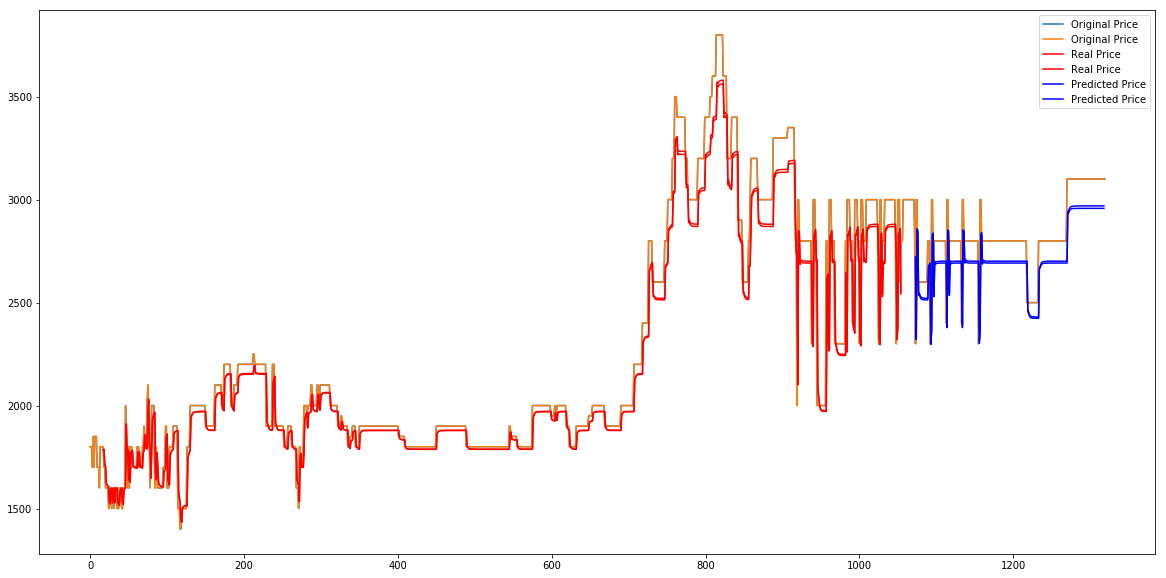

In [280]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled),label = 'Original Price')
plt.plot(trainPredictPlot, color = 'red', label = 'Real Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Price')
plt.legend()
#plt.plot(x='Arrival Date')
plt.show()